In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import gc
import time
import re
import unicodedata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import random

import nltk                         # import NLTK to handle simple NL tasks like tokenization.
nltk.download("punkt")
from nltk.util import ngrams
from collections import Counter     # import the Counter module.
#!pip3 install 'sacrebleu'           # install the sacrebleu package.
import sacrebleu                    # import sacrebleu in order compute the BLEU score.

import statistics

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Global parameters
#root folder
root_folder='/content/drive/MyDrive/machine-translation/'
#data_folder='.'
data_folder_name='corpus/spa-eng'
train_filename='spa.txt'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

In [4]:
train_filenamepath

'/content/drive/MyDrive/machine-translation/corpus/spa-eng/spa.txt'

In [5]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 120000 #40000
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
HIDDEN_DIM=1024 #512

BATCH_SIZE = 128  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.

ATTENTION_FUNC='general'

In [6]:
#Preprocessing the data
# Some function to preprocess the text data, taken from the Neural machine translation with attention tutorial in Tensorflow
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    ''' Preprocess the input text w applying lowercase, removing accents, 
    creating a space between a word and the punctuation following it and 
    replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    Input:
        - w: a string, input text
    Output:
        - a string, the cleaned text
    '''
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    #w = '<start> ' + w + ' <end>'
    
    return w

In [7]:
# Load the dataset: sentence in english, sentence in spanish 
df=pd.read_csv(train_filenamepath, sep="\t", header=None, names=[TARGET_COLUMN,INPUT_COLUMN], usecols=[0,1], 
               nrows=NUM_SAMPLES)

In [8]:
df

,target,input
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.
...,...,...
119995,What happened to the book I put here yesterday?,¿Qué le pasó al libro que dejé aquí ayer?
119996,What on earth do you want to talk to Tom about?,¿De qué diablos quieres hablar con Tom?
119997,What time was it when you entered the building?,¿Qué hora era cuando entraste en el edificio?
119998,What we want to do next is check the oil level.,Lo que queremos hacer es medir el nivel de ace...


In [9]:
train, test = train_test_split(df, test_size=0.2)

In [10]:
train

,target,input
72144,Tom is up to his neck in debt.,Tom está endeudado hasta el cuello.
112205,I have the money that you're talking about.,Tengo el dinero del que hablas.
76849,Typhus is a contagious disease.,El tifus es una enfermedad contagiosa.
73279,Did Tom give you back your pen?,¿Tom te ha devuelto tu bolígrafo?
112769,She was good at mathematics in high school.,Ella era buena para las matemáticas en la ense...
...,...,...
78273,His wife is our Italian teacher.,Su esposa es nuestra profesora de italiano.
80674,Tom and Mary used to be friends.,Tom y María solían ser amigos.
31215,Coffee keeps me awake.,El café me mantiene despierto.
39717,We just want our share.,Simplemente queremos nuestra parte.


In [11]:
test

,target,input
70271,I want to ask you a big favor.,Quiero pedirte un gran favor.
17033,The truck is gone.,El camión se ha ido.
7671,May I help you?,¿Puedo ayudarle?
63001,Tom is the guy who hit Mary.,Tom es el hombre que golpeó a Mary.
63863,"Would you stop that, please?","¿Puedes parar eso, por favor?"
...,...,...
47984,She looks at least sixty.,Parece tener al menos sesenta años.
114669,The author dedicated the book to his sister.,El autor dedicó el libro a su hermana.
115397,You're the only one who volunteered to help.,Tú eres la única que se presentó voluntaria pa...
60272,I can get you what you want.,Puedo darte lo que quieres.


In [12]:
# Preprocess the input data
input_data=train[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=train[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is right shifted
target_input_data=train[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()

print(input_data[:3])
print(target_data[:3])
print(target_input_data[:3])

['tom esta endeudado hasta el cuello .', 'tengo el dinero del que hablas .', 'el tifus es una enfermedad contagiosa .']
['tom is up to his neck in debt . <eos>', 'i have the money that you re talking about . <eos>', 'typhus is a contagious disease . <eos>']
['<sos> tom is up to his neck in debt .', '<sos> i have the money that you re talking about .', '<sos> typhus is a contagious disease .']


In [13]:
# Create a tokenizer for the input texts(Spanish) and fit it to them 
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_inputs.fit_on_texts(input_data)
# Tokenize and transform input texts to sequence of integers
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)
# Claculate the max length
input_max_len = max(len(s) for s in input_sequences)
print('Max Input Length: ', input_max_len)
# Show some example of tokenize sentences, useful to check the tokenization
print(input_data[19995])
print(input_sequences[19995])


Max Input Length:  18
¿ existe algun riesgo ?
[9, 2355, 360, 1729, 8]


In [14]:
# tokenize the outputs(English)
# don't filter out special characters (filters = '')
# otherwise <sos> and <eos> won't appear
# By default, Keras’ Tokenizer will trim out all the punctuations, which is not what we want. 
# we can just set filters as blank here.

# Create a tokenizer for the output texts and fit it to them 
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data)
tokenizer_outputs.fit_on_texts(target_input_data)
# Tokenize and transform output texts to sequence of integers
target_sequences = tokenizer_outputs.texts_to_sequences(target_data)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_input_data)

# determine maximum length output sequence
target_max_len = max(len(s) for s in target_sequences)
print('Max Target Length: ', target_max_len)

print(target_data[19995])
print(target_sequences[19995])
print(target_input_data[19995])
print(target_sequences_inputs[19995])

Max Target Length:  16
are there any risks ? <eos>
[32, 46, 129, 2559, 9, 2]
<sos> are there any risks ?
[3, 32, 46, 129, 2559, 9]


In [15]:
#Creating Vocabularies
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output and input words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
num_words_inputs = len(word2idx_inputs) + 1

# map indexes back into real words
# so we can view the results
idx2word_inputs = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

Found 20944 unique input tokens.
Found 10983 unique output tokens.


In [16]:
#Padding - necessary to pad the sentences with 0 at the end so all the sentences have the smae length
# pad the input sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])
# pad the decoder input sequences
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=target_max_len, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)
# pad the target output sequences
decoder_targets = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')

encoder_inputs.shape: (96000, 18)
encoder_inputs[0]: [   5   16 6098  158    3 1635    1    0    0    0    0    0    0    0
    0    0    0    0]
decoder_inputs[0]: [   3    8   12   63    7   37 1658   17 1968    1    0    0    0    0
    0    0]
decoder_inputs.shape: (96000, 16)


In [17]:
#Creating a batch data generator 
#Since we want to train our model in batches we need to create a dataset using tf.data library.
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_inputs, decoder_targets))
dataset = dataset.shuffle(len(input_data)).batch(
    BATCH_SIZE, drop_remainder=True)

In [18]:
#Encoder Function
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        # Define the embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define the RNN layer, LSTM
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)

    def call(self, input_sequence, states):
        # Embed the input
        embed = self.embedding(input_sequence)
        # Call the LSTM unit
        output, state_h, state_c = self.lstm(embed, initial_state=states)

        return output, state_h, state_c

    def init_states(self, batch_size):
        # Return a all 0s initial states
        return (tf.zeros([batch_size, self.hidden_dim]),
                tf.zeros([batch_size, self.hidden_dim]))

In [19]:
#Attention Class
class LuongAttention(tf.keras.Model):
    def __init__(self, rnn_size, attention_func):
        super(LuongAttention, self).__init__()
        self.attention_func = attention_func

        if attention_func not in ['dot', 'general', 'concat']:
            raise ValueError(
                'Attention score must be either dot, general or concat.')

        if attention_func == 'general':
            # General score function
            self.wa = tf.keras.layers.Dense(rnn_size)
        elif attention_func == 'concat':
            # Concat score function
            self.wa = tf.keras.layers.Dense(rnn_size, activation='tanh')
            self.va = tf.keras.layers.Dense(1)

    def call(self, decoder_output, encoder_output):
        if self.attention_func == 'dot':
            # Dot score function: decoder_output (dot) encoder_output
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, encoder_output, transpose_b=True) # (batch_size, 1, max_len)
        elif self.attention_func == 'general':
            # General score function: decoder_output (dot) (Wa (dot) encoder_output)
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, self.wa(
                encoder_output), transpose_b=True) #(batch_size, 1, max_len)
        elif self.attention_func == 'concat':
            # Concat score function: va (dot) tanh(Wa (dot) concat(decoder_output + encoder_output))
            # Decoder output must be broadcasted to encoder output's shape first
            decoder_output = tf.tile(
                decoder_output, [1, encoder_output.shape[1], 1]) #shape (batch size, max len,hidden_dim)

            # Concat => Wa => va
            # (batch_size, max_len, 2 * rnn_size) => (batch_size, max_len, rnn_size) => (batch_size, max_len, 1)
            score = self.va(
                self.wa(tf.concat((decoder_output, encoder_output), axis=-1))) # (batch_size, max len, 1)

            # Transpose score vector to have the same shape as other two above
            # (batch_size, max_len, 1) => (batch_size, 1, max_len)
            score = tf.transpose(score, [0, 2, 1]) #(batch_size, 1, max_len)

        # alignment a_t = softmax(score)
        alignment = tf.keras.activations.softmax(score, axis=-1) #(batch_size, 1, max_len)
        
        # context vector c_t is the weighted average sum of encoder output
        context = tf.matmul(alignment, encoder_output) # (batch_size, 1, hidden_dim)

        return context, alignment

In [20]:
#Creating the Decoder Class
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, attention_func):
        super(Decoder, self).__init__()
        self.attention = LuongAttention(hidden_dim, attention_func)
        self.hidden_dim = hidden_dim
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)
        self.wc = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

    def call(self, input_sequence, state, encoder_output):
        # Remember that the input to the decoder
        # is now a batch of one-word sequences,
        # which means that its shape is (batch_size, 1)
        embed = self.embedding(input_sequence)

        # Therefore, the lstm_out has shape (batch_size, 1, hidden_dim)
        lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)

        # Use self.attention to compute the context and alignment vectors
        # context vector's shape: (batch_size, 1, hidden_dim)
        # alignment vector's shape: (batch_size, 1, source_length)
        context, alignment = self.attention(lstm_out, encoder_output)

        # Combine the context vector and the LSTM output
        # Before combined, both have shape of (batch_size, 1, hidden_dim),
        # so let's squeeze the axis 1 first
        # After combined, it will have shape of (batch_size, 2 * hidden_dim)
        lstm_out = tf.concat(
            [tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)

        # lstm_out now has shape (batch_size, hidden_dim)
        lstm_out = self.wc(lstm_out)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.ws(lstm_out)

        return logits, state_h, state_c, alignment

In [21]:
#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1
#Create the encoder
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM, ATTENTION_FUNC)

# Call the encoder and then the decoder
initial_state = encoder.init_states(1)
encoder_outputs = encoder(tf.constant([[1]]), initial_state)
decoder_outputs = decoder(tf.constant(
    [[1]]), encoder_outputs[1:], encoder_outputs[0])

In [22]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    # Mask padding values, they do not have to compute for loss
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    # Calculate the loss value
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
  
    return n_correct / n_total

In [23]:
#Training Function
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    ''' A training step, train a batch of the data and return the loss value reached
        Input:
        - input_seq: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence
        - target_seq_out: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the target seq, our target sequence
        - target_seq_in: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence to the decoder, we use Teacher Forcing
        - en_initial_states: tuple of arrays of shape [batch_size, hidden_dim].
            the initial state of the encoder
        - optimizer: a tf.keras.optimizers.
        Output:
        - loss: loss value
        
    '''
    loss = 0.
    acc = 0.
    logits = None
    
    with tf.GradientTape() as tape:
        en_outputs = encoder(input_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states

        # We need to create a loop to iterate through the target sequences
        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(
                decoder_in, (de_state_h, de_state_c), en_outputs[0])

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)
            # Store the logits to calculate the accuracy
            logit = K.expand_dims(logit, axis=1)
            if logits is None:
                logits = logit
            else:
                logits = K.concatenate((logits,logit), axis=1)
        # Calculate the accuracy for the batch data        
        acc = accuracy_fn(target_seq_out, logits)
    # Update the parameters and the optimizer
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1], acc

In [24]:
# Create the main train function
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
    
    losses = []
    accuracies = []

    for e in range(n_epochs):
        # Get the initial time
        start = time.time()
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        # For every batch data
        for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
            # Train and get the loss value 
            loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
        
            if batch % 100 == 0:
                # Store the loss and accuracy values
                losses.append(loss)
                accuracies.append(accuracy)
                print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
                
        # saving (checkpoint) the model every 2 epochs
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses, accuracies

In [25]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = '/content/drive/MyDrive/machine-translation/corpus/spa-eng/training_ckpt_seq2seq_att'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 4.5659 Acc:0.0000
Epoch 1 Batch 100 Loss 2.4548 Acc:0.2617
Epoch 1 Batch 200 Loss 2.1960 Acc:0.2874
Epoch 1 Batch 300 Loss 2.0680 Acc:0.3488
Epoch 1 Batch 400 Loss 1.8521 Acc:0.3750
Epoch 1 Batch 500 Loss 1.7458 Acc:0.4135
Epoch 1 Batch 600 Loss 1.6704 Acc:0.4117
Epoch 1 Batch 700 Loss 1.6232 Acc:0.4300
Time taken for 1 epoch 183.4051 sec

Epoch 2 Batch 0 Loss 1.5719 Acc:0.4413
Epoch 2 Batch 100 Loss 1.5508 Acc:0.4512
Epoch 2 Batch 200 Loss 1.5344 Acc:0.4637
Epoch 2 Batch 300 Loss 1.4281 Acc:0.4661
Epoch 2 Batch 400 Loss 1.3235 Acc:0.5054
Epoch 2 Batch 500 Loss 1.3283 Acc:0.5074
Epoch 2 Batch 600 Loss 1.2869 Acc:0.5104
Epoch 2 Batch 700 Loss 1.3070 Acc:0.5180
Time taken for 1 epoch 169.2189 sec

Epoch 3 Batch 0 Loss 1.1260 Acc:0.5488
Epoch 3 Batch 100 Loss 1.0639 Acc:0.5494
Epoch 3 Batch 200 Loss 1.1386 Acc:0.5553
Epoch 3 Batch 300 Loss 1.0609 Acc:0.5682
Epoch 3 Batch 400 Loss 1.0451 Acc:0.5879
Epoch 3 Batch 500 Loss 1.0236 Acc:0.5837
Epoch 3 Batch 600 Loss 1.1811 

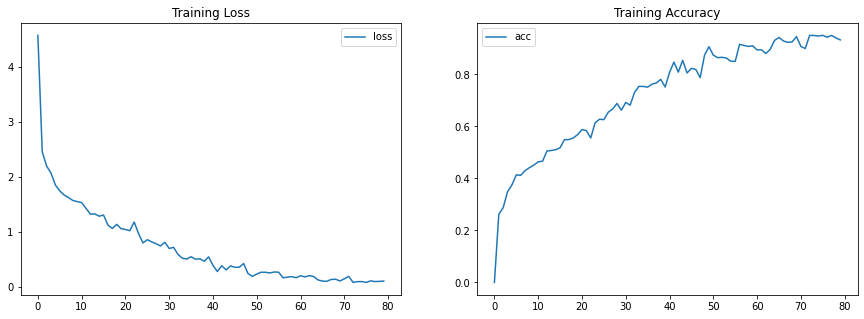

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [ ]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = '/content/drive/MyDrive/machine-translation/corpus/spa-eng/training_ckpt_seq2seq_att'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [55]:
predicted_list = []

In [51]:
def predict_seq2seq_att(input_text, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
    #print(input_text)
    # Tokenize the input text
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    # Get the encoder initial states
    en_initial_states = encoder.init_states(1)
    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Set the decoder input to the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    alignments = []

    while True:
        # Get the decoder with attention output
        de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        # Detokenize the output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Save the aligment matrix
        alignments.append(alignment.numpy())

        if out_words[-1] == '<eos>' or len(out_words) >= 20:
            break
    # Join the output words
    #print(' '.join(out_words))
    out_words = ' '.join(out_words)
    predicted_list.append(out_words)
    print('Predicted English Text - ',out_words)
    return np.array(alignments), input_text.split(' '), out_words, predicted_list

In [52]:
# Preprocess the input data
input_data_test = test[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data_test = test[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is right shifted
target_input_data_test = test[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()
print(input_data_test[:10])
print(target_data_test[:10])
print(target_input_data_test[:10])

['quiero pedirte un gran favor .', 'el camion se ha ido .', '¿ puedo ayudarle ?', 'tom es el hombre que golpeo a mary .', '¿ puedes parar eso , por favor ?', '¿ cuanto tiempo te vas a quedar en kioto ?', 'no eres mi novia .', 'deberiamos hacerlo mas a menudo .', 'creo que deberias posponer la reunion .', '¿ por que no almorzamos juntos ?']
['i want to ask you a big favor . <eos>', 'the truck is gone . <eos>', 'may i help you ? <eos>', 'tom is the guy who hit mary . <eos>', 'would you stop that , please ? <eos>', 'how long will you stay in kyoto ? <eos>', 'you re not my girlfriend . <eos>', 'we should do this more often . <eos>', 'i think you ought to postpone the meeting . <eos>', 'why don t we have lunch together ? <eos>']
['<sos> i want to ask you a big favor .', '<sos> the truck is gone .', '<sos> may i help you ?', '<sos> tom is the guy who hit mary .', '<sos> would you stop that , please ?', '<sos> how long will you stay in kyoto ?', '<sos> you re not my girlfriend .', '<sos> we s

In [53]:
for test_sent, test_output in zip(input_data_test[:10], target_data_test[:10]):
    print('Input Spanish Text - ', test_sent)
    print('Target English Text - ', test_output)
    predict_seq2seq_att(test_sent, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs)
    print('\n')

Input Spanish Text -  quiero pedirte un gran favor .
Target English Text -  i want to ask you a big favor . <eos>
Predicted English Text -  i want to ask you a big favor . <eos>


Input Spanish Text -  el camion se ha ido .
Target English Text -  the truck is gone . <eos>
Predicted English Text -  he has gone off . <eos>


Input Spanish Text -  ¿ puedo ayudarle ?
Target English Text -  may i help you ? <eos>
Predicted English Text -  can i help you ? <eos>


Input Spanish Text -  tom es el hombre que golpeo a mary .
Target English Text -  tom is the guy who hit mary . <eos>
Predicted English Text -  tom is the man who hit mary . <eos>


Input Spanish Text -  ¿ puedes parar eso , por favor ?
Target English Text -  would you stop that , please ? <eos>
Predicted English Text -  could you please leave me ? <eos>


Input Spanish Text -  ¿ cuanto tiempo te vas a quedar en kioto ?
Target English Text -  how long will you stay in kyoto ? <eos>
Predicted English Text -  how long are you going t

In [56]:
predicted_list

[]

In [58]:
for test_sent, test_output in zip(input_data_test[:10000], target_data_test[:10000]):
    predict_seq2seq_att(test_sent, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs)

Streaming output truncated to the last 5000 lines.
Predicted English Text -  i ve been a disappointment to my parents . <eos>
Predicted English Text -  here s a pen . <eos>
Predicted English Text -  i d like to earn more money . <eos>
Predicted English Text -  we should help . <eos>
Predicted English Text -  i don t mince words . <eos>
Predicted English Text -  she is attractive , but she talks too much . <eos>
Predicted English Text -  i waited for him to the bus . <eos>
Predicted English Text -  what kind of meal do you eat ? <eos>
Predicted English Text -  she is used to talking in public . <eos>
Predicted English Text -  tom says that isn t fair . <eos>
Predicted English Text -  it s right to go . <eos>
Predicted English Text -  sit down on the table . <eos>
Predicted English Text -  the men are having lunch . <eos>
Predicted English Text -  how can i do it ? <eos>
Predicted English Text -  where s your watch ? <eos>
Predicted English Text -  step on the rope . <eos>
Predicted Engl

In [59]:
print(len(predicted_list))
predicted_list[:10]

10000


['i want to ask you a big favor . <eos>',
 'he has gone off . <eos>',
 'can i help you ? <eos>',
 'tom is the man who hit mary . <eos>',
 'could you please leave me ? <eos>',
 'how long are you going to stay in japan ? <eos>',
 'you re not my girlfriend . <eos>',
 'we should do more than write more . <eos>',
 'i think you should finish the meeting . <eos>',
 'why didn t we eat lunch together ? <eos>']

In [60]:
print(len(target_data_test))
target_data_test[:10]

24000


['i want to ask you a big favor . <eos>',
 'the truck is gone . <eos>',
 'may i help you ? <eos>',
 'tom is the guy who hit mary . <eos>',
 'would you stop that , please ? <eos>',
 'how long will you stay in kyoto ? <eos>',
 'you re not my girlfriend . <eos>',
 'we should do this more often . <eos>',
 'i think you ought to postpone the meeting . <eos>',
 'why don t we have lunch together ? <eos>']

In [61]:
#BLEU SCORE using our own function
#Bleu = Brevity Penalty * precision
def brevity_penalty(reference, candidate):
    ref_length = len(reference)
    can_length = len(candidate)

    # Brevity Penalty
    if ref_length > can_length:
        BP = 1
    else:
        penalty = 1 - (ref_length / can_length)
        BP = np.exp(penalty)

    return BP

In [62]:
def clipped_precision(reference, candidate):
    """
    Bleu score function given a original and a machine translated sentences
    """

    clipped_precision_score = []

    for i in range(1, 5):
        candidate_n_gram = Counter(
            ngrams(candidate, i)
        )  # counts of n-gram n=1...4 tokens for the candidate
        reference_n_gram = Counter(
            ngrams(reference, i)
        )  # counts of n-gram n=1...4 tokens for the reference

        c = sum(
            reference_n_gram.values()
        )  # sum of the values of the reference the denominator in the precision formula

        for j in reference_n_gram:  # for every n_gram token in the reference
            if j in candidate_n_gram:  # check if it is in the candidate n-gram

                if (
                    reference_n_gram[j] > candidate_n_gram[j]
                ):  # if the count of the reference n-gram is bigger
                    # than the corresponding count in the candidate n-gram
                    reference_n_gram[j] = candidate_n_gram[
                        j
                    ]  # then set the count of the reference n-gram to be equal
                    # to the count of the candidate n-gram
            else:

                reference_n_gram[j] = 0  # else reference n-gram = 0

        clipped_precision_score.append(sum(reference_n_gram.values()) / c)

    weights = [0.25] * 4

    s = (w_i * np.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score))
    s = np.exp(np.sum(s))
    return s

In [63]:
def bleu_score(reference, candidate):
    BP = brevity_penalty(reference, candidate)
    precision = clipped_precision(reference, candidate)
    return BP * precision

In [64]:
#Word Tokenizing every element in the reference and candidate list
bleu = []
for tokenized_ref, tokenized_can in zip(target_data_test[:10000], predicted_list): 
    score = round(bleu_score(tokenized_ref, tokenized_can) * 100, 1)
    bleu.append(score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [65]:
statistics.mean(bleu)

72.30787

In [66]:
#SacreBleu Score
#Word Tokenizing every element in the reference and candidate list
bleu_score = []
for tokenized_ref, tokenized_can in zip(target_data_test, predicted_list): 
    score = round(sacrebleu.corpus_bleu(tokenized_ref, tokenized_can).score, 1)
    bleu_score.append(score)

In [67]:
statistics.mean(bleu_score)

54.39593

In [68]:
#Not sure if correct. might have some error
from nltk.translate.bleu_score import sentence_bleu
nltk_bleu_score = []
for tokenized_ref, tokenized_can in zip(target_data_test, predicted_list): 
    score = sentence_bleu(tokenized_ref, tokenized_can)
    nltk_bleu_score.append(score)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [69]:
statistics.mean(nltk_bleu_score)

0.82054019487184